# Loan Default Prediction Model - K-Nearest Neighbors (KNN)
This notebook aims to predict loan default outcomes based on historical loan data. The approach includes data preprocessing, model training, and evaluation using the K-nearest neighbors algorithm from the `sklearn` library. 

## Contents

Step 1. Data Loading and Initial Setup

Step 2. Data Preprocessing

Step 3. Feature Engineering

Step 4. KNN Model

## Step 1. Data Loading and Initial Setup

In [1]:
import pandas as pd
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score, confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 2. Data Preprocessing

To prepare our dataset, we will:
1. Drop non-numerical and irrelevant columns.
2. Separate the target variable (loan status) from the features.
3. Identify numerical and categorical features for encoding and scaling.

In [2]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

## Step 3. Feature Engineering

We'll now split the columns into numerical and categorical types. Categorical variables will be one-hot encoded, and numerical variables will be scaled to improve model performance.

In [3]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64','int64']).columns 

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Drop rows with NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Ensure y_train matches X_train, y_test matches X_test
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# Step 4. KNN Model

We use recall score to look for the best value of k for our KNN model.

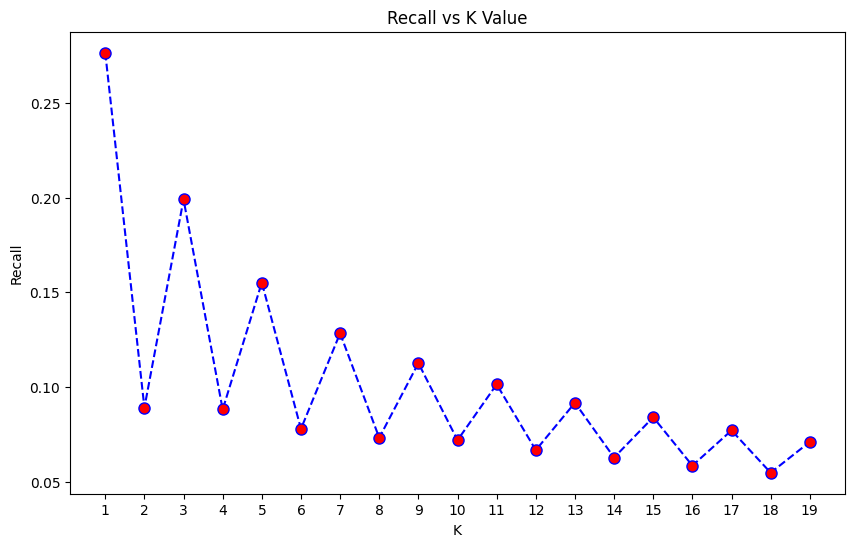

Optimal k for maximum recall: 1 with recall score: 0.277


In [4]:
# List to store recall scores for each k
recall_scores = []

for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  # Fit the model with training data
    y_pred = knn.predict(X_test)  # Predict on test data
    
    # Calculate recall and add to list
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)

# Plotting recall vs k values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), recall_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Recall vs K Value')
plt.xlabel('K')
plt.ylabel('Recall')
plt.xticks(np.arange(1, 20, 1))
plt.show()

# Find and print the optimal k
optimal_k = np.argmax(recall_scores) + 1  # +1 because index starts at 0
print(f"Optimal k for maximum recall: {optimal_k} with recall score: {max(recall_scores):.3f}")

Accuracy: 0.76 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.94      0.86     40328
         1.0       0.38      0.13      0.19     11228

    accuracy                           0.76     51556
   macro avg       0.59      0.53      0.53     51556
weighted avg       0.70      0.76      0.72     51556



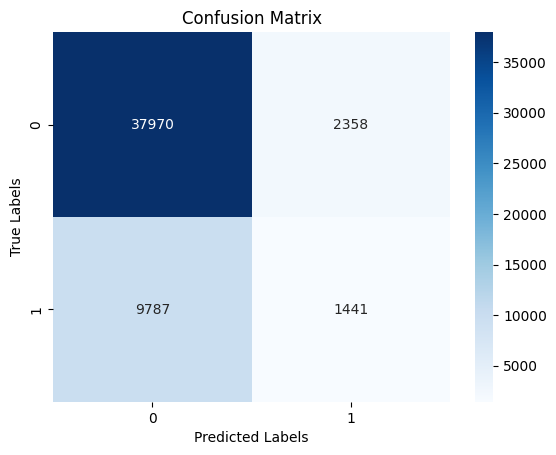

In [5]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}', "\n")
print("Classification Report:\n", class_report)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Alternatively, we can also use knn regressor to get the probability threshold

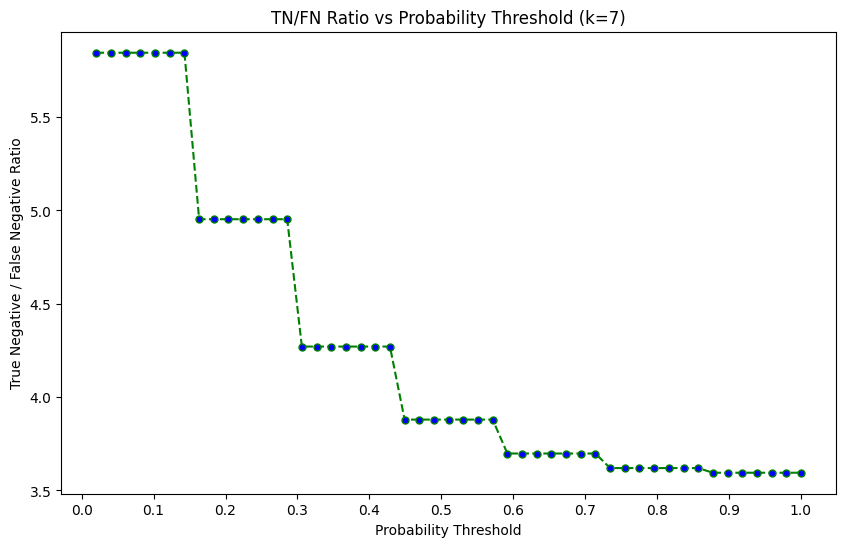

In [8]:
k = 7  # Replace 'optimal_k' with the chosen k value

# Initialize and fit the KNN Regressor with the chosen k
knn_reg = KNeighborsRegressor(n_neighbors=k)
knn_reg.fit(X_train, y_train)

# Predict probabilities (interpreted as probability of default)
y_pred_proba = knn_reg.predict(X_test)

# Define probability thresholds to evaluate
thresholds = np.linspace(0, 1, 50)  # Adjust number of thresholds as needed
tn_fn_ratios = []

# Calculate TN/FN ratios for each threshold
for threshold in thresholds:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    
    # Calculate TN/FN ratio (avoid division by zero)
    tn_fn_ratio = tn / fn if fn != 0 else np.nan
    tn_fn_ratios.append(tn_fn_ratio)

# Plotting TN/FN ratio vs Probability Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tn_fn_ratios, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=5)
plt.title(f'TN/FN Ratio vs Probability Threshold (k={k})')
plt.xlabel('Probability Threshold')
plt.ylabel('True Negative / False Negative Ratio')
plt.xticks(np.linspace(0, 1, 11))
plt.show()